In [1]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
import matplotlib.pyplot as plt

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
class variational_lstm(tf.keras.Model):
    def __init__(self,data,num_latent):
        super(variational_lstm,self).__init__()
        
        # Set up the data for the LSTM
        self.data_tsteps = np.shape(data)[0]
        self.state_len = np.shape(data)[1]

#         self.preproc_pipeline = Pipeline([('stdscaler', StandardScaler()),('minmax', MinMaxScaler(feature_range=(-1, 1)))])
        self.preproc_pipeline = Pipeline([('minmax', MinMaxScaler())])
        self.data = self.preproc_pipeline.fit_transform(data)
        
        # Need to make minibatches
        self.seq_num = 8
        self.total_size = np.shape(data)[0]

        input_seq = np.zeros(shape=(self.total_size,self.seq_num,self.state_len))  #[samples,n_inputs,state_len]
        output_seq = np.zeros(shape=(self.total_size,self.seq_num,self.state_len)) #[samples,n_outputs,state_len]

        snum = 0
        for t in range(0,self.total_size):
            try:
                input_seq[snum] = self.data[None,t:t+self.seq_num,:]
                output_seq[snum] = self.data[None,t+self.seq_num:t+2*self.seq_num,:]        
                snum = snum + 1
            except:
                print('Max data length reached: Truncating collection')
                input_seq = input_seq[:snum]
                output_seq = output_seq[:snum]
                break

        # Shuffle dataset
        idx = np.arange(snum)
        np.random.shuffle(idx)
        input_seq = input_seq[idx]
        output_seq = output_seq[idx]

        # Split into train and valid
        self.ntrain = int(0.8*snum)
        self.nvalid = snum - self.ntrain

        self.input_seq_train = input_seq[:self.ntrain]
        self.output_seq_train = output_seq[:self.ntrain]

        self.input_seq_valid = input_seq[self.ntrain:]
        self.output_seq_valid = output_seq[self.ntrain:]
        
        # Constants
        self.num_latent = num_latent
        
        # Initializer
        xavier = tf.keras.initializers.GlorotUniform()
        
        # Define inference architecture
        # Encoder
        self.l1=tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(20,return_sequences=True,input_shape=(self.seq_num,self.state_len))
        )
        # Latent space
        self.latent_mu = tf.keras.layers.Dense(self.num_latent,activation='linear')
        self.latent_logvar = tf.keras.layers.Dense(self.num_latent,activation='linear')
        
        # Decoder
        self.l2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True))
        self.out = tf.keras.layers.Dense(self.state_len,activation='linear')
        
        # optimizer
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.mse = tf.keras.losses.MeanSquaredError()
        
    def call(self,X):
        # Call inference
        h1 = self.l1(X)
               
        # Variational assumption quantities
        self.mu = self.latent_mu(h1)
        self.logvar = self.latent_logvar(h1)
        
        # Shapes
        batch_size = tf.shape(self.mu)[0]
        nl = self.num_latent
        
        # Batch wise latent space operations
        eps = tf.random.normal(shape=(batch_size,self.seq_num,nl),mean=0.0,stddev=1.0)
        self.Z = self.mu + tf.math.sqrt(tf.math.exp(self.logvar))*eps
        
        # Decoder
        out = self.out(self.l2(self.Z))
        
        return out
    
    def get_loss(self,X,Y):
        Ypred = self.call(X) # MSE
        
        kl_loss = 1 + self.logvar - tf.math.square(self.mu) - tf.math.exp(self.logvar)
        kl_loss = -0.5*tf.reduce_sum(kl_loss) # KL Divergence
        
        return self.mse(Y,Ypred) + kl_loss

    def get_grad(self,X,Y):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(X,Y)
            g = tape.gradient(L, self.trainable_variables)
        return g
    
    # perform gradient descent - regular
    def network_learn(self,X,Y):
        g = self.get_grad(X,Y)
        self.train_op.apply_gradients(zip(g, self.trainable_variables))
           
    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 10
        best_valid_loss = 999999.0 # Some large number 

        self.num_batches = 20
        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int((self.nvalid)/self.num_batches)
        
        for i in range(100):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                input_batch = self.input_seq_train[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                output_batch = self.output_seq_train[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(input_batch,output_batch)

            # Validation loss
            valid_loss = 0.0
            valid_r2 = 0.0

            for batch in range(self.num_batches):
                input_batch = self.input_seq_valid[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                output_batch = self.output_seq_valid[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]

                valid_loss = valid_loss + self.get_loss(input_batch,output_batch).numpy()
                predictions = self.call(self.input_seq_valid).numpy()
                valid_r2 = valid_r2 + \
                            r2_score(
                                predictions.reshape(self.valid_batch_size,-1),
                                self.output_seq_valid.reshape(self.valid_batch_size,-1)
                            )

            valid_r2 = valid_r2/(batch+1)


            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation loss from:',best_valid_loss,' to:', valid_loss)
                print('Validation R2:',valid_r2)
                
                best_valid_loss = valid_loss
                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation loss (no improvement):',valid_loss)
                print('Validation R2:',valid_r2)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                break

    # Load weights
    def restore_model(self):
        self.load_weights('./checkpoints/my_checkpoint') # Load pretrained model

    # Do some testing
    def model_inference(self,test_data):
        # Restore from checkpoint
        self.restore_model()

        # Scale testing data
        test_data = self.preproc_pipeline.transform(test_data)

        # Test sizes
        test_total_size = np.shape(test_data)[0]

        # Input placeholder setup
        rec_input_seq = test_data[:self.seq_num,:].reshape(1,self.seq_num,self.state_len)
        
        # True outputs
        rec_output_seq = np.zeros(shape=(test_total_size,self.seq_num,self.state_len)) #[samples,n_outputs,state_len]
        snum = 0
        for t in range(0,test_total_size,self.seq_num):
            try:
                rec_output_seq[snum] = test_data[None,t+self.seq_num:t+2*self.seq_num,:]        
                snum = snum + 1
            except:
                print('Max data length reached: Truncating collection')
                rec_output_seq = rec_output_seq[:snum]
                break

        # One step predict
        rec_pred = np.copy(rec_output_seq)
        for t in range(0,snum):
            rec_pred[t] = self.call(rec_input_seq).numpy()[0]
            rec_input_seq[0] = rec_output_seq[t]
            
        # Reshape for rescaling
        rec_pred = rec_pred.reshape(snum*self.seq_num,-1)
        rec_output_seq = rec_output_seq.reshape(snum*self.seq_num,-1)
        
        # Rescale
        rec_pred = self.preproc_pipeline.inverse_transform(rec_pred)
        rec_output_seq = self.preproc_pipeline.inverse_transform(rec_output_seq)

        # plot
        rec_pred = rec_pred.reshape(-1,self.state_len)
        rec_output_seq = rec_output_seq.reshape(-1,self.state_len)
        for i in range(self.state_len):
            plt.figure()
            plt.title('Mode '+str(i))
            plt.plot(rec_pred[:,i],label='Predicted')
            plt.plot(rec_output_seq[:,i],label='True')
            plt.legend()
            plt.show()

        return rec_output_seq, rec_pred

In [3]:
# Loading data
data = np.load('SST_Train.npy').T
# Preprocessing
state_scaler = MinMaxScaler()
scaled_data = state_scaler.fit_transform(data)

In [4]:
# Initialize model
num_latent = 10
var_model = variational_lstm(scaled_data,num_latent)
# Training model
var_model.train_model() # Train and exit

Max data length reached: Truncating collection
Training iteration: 0
Improved validation loss from: 999999.0  to: 19.54372537136078
Validation R2: -65.99234543005937
Training iteration: 1
Improved validation loss from: 19.54372537136078  to: 11.027736723423004
Validation R2: -50.77030334255889
Training iteration: 2
Improved validation loss from: 11.027736723423004  to: 6.7738518714904785
Validation R2: -31.072093441541472
Training iteration: 3
Improved validation loss from: 6.7738518714904785  to: 4.820003911852837
Validation R2: -21.187526483878848
Training iteration: 4
Improved validation loss from: 4.820003911852837  to: 3.985843747854233
Validation R2: -24.791375765547635
Training iteration: 5
Improved validation loss from: 3.985843747854233  to: 3.331420049071312
Validation R2: -36.63530672278006
Training iteration: 6
Improved validation loss from: 3.331420049071312  to: 2.8916161954402924
Validation R2: -37.470926665679045
Training iteration: 7
Improved validation loss from: 2.89

Validation loss (no improvement): 1.5287379547953606
Validation R2: -283.502010374076
Training iteration: 68
Validation loss (no improvement): 1.5373863577842712
Validation R2: -266.77011056300233
Training iteration: 69
Validation loss (no improvement): 1.5299417972564697
Validation R2: -296.7412468537916
Training iteration: 70
Validation loss (no improvement): 1.523084007203579
Validation R2: -274.3663873975256
Training iteration: 71
Validation loss (no improvement): 1.5370113402605057
Validation R2: -262.1036048730632
Training iteration: 72
Validation loss (no improvement): 1.542463794350624
Validation R2: -323.3022585342443
Training iteration: 73
Improved validation loss from: 1.5225044637918472  to: 1.5203164666891098
Validation R2: -307.64164126004505
Training iteration: 74
Improved validation loss from: 1.5203164666891098  to: 1.5143211521208286
Validation R2: -287.24250918763636
Training iteration: 75
Validation loss (no improvement): 1.531879484653473
Validation R2: -289.746575

Max data length reached: Truncating collection


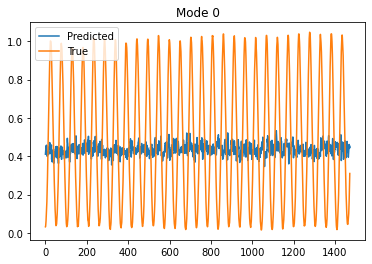

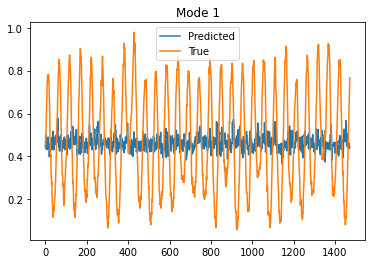

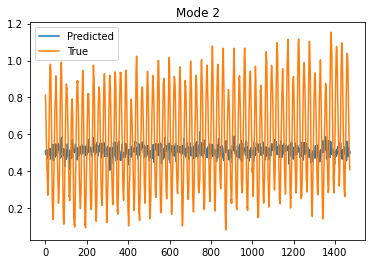

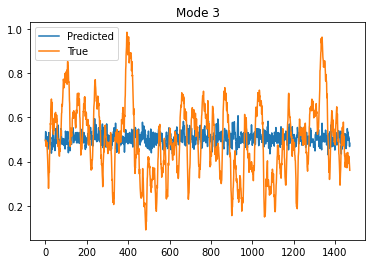

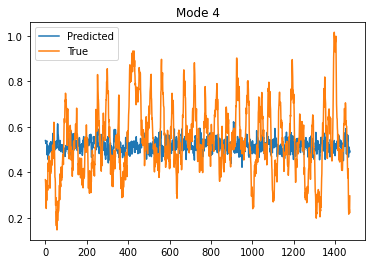

In [5]:
test_data = np.load('SST_Test.npy').T
scaled_test_data = state_scaler.transform(test_data)
true, predicted = var_model.model_inference(scaled_test_data) # Do some inference